# Affinity Propagation

今天要介紹分群的方法叫做 親合傳播 （ Affinity Propagation ）， 
其概念引申自 [Clustering by Passing Messages Between Data Points](https://utstat.toronto.edu/reid/sta414/frey-affinity.pdf) 這篇論文，

使用 Affinity Propagation 的好處是，
我們不用先設定好要分幾類，演算法會自動決定有幾種分類，
Affinity Propagation 的運作方法，是會在任一對的兩點之間互相傳遞親合度，
就像是在各點間經過多輪的投票，
等到投票的結果收斂後就會知道有幾類，
所以模型裡面有個參數 ``damping`` 要去設定，
預設值是 $0.5$ ，範圍介於 $[0.5, 1.0)$ 之間，參數目的是怕親合度傳遞的結果不收斂，
在開始繼續講其原理細節之前，我們先來看看實際上怎麼使用他，
以鳶尾花資料集為例。


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AffinityPropagation
from sklearn import datasets
from sklearn.decomposition import PCA


X, y = datasets.load_iris(return_X_y=True)

# Affinity Propagation method
model = AffinityPropagation(damping=0.97).fit(X)
labels = model.labels_
cluster_centers = model.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

cluster_centers



array([[5. , 3.4, 1.5, 0.2],
       [6. , 2.9, 4.5, 1.5],
       [7.6, 3. , 6.6, 2.1],
       [6.8, 3. , 5.5, 2.1]])

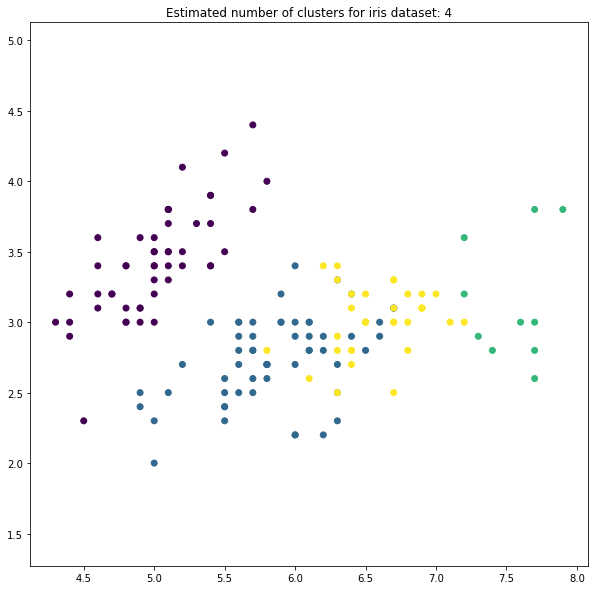

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AffinityPropagation
from sklearn import datasets
from sklearn.decomposition import PCA

X, y = datasets.load_iris(return_X_y=True)
X_pca = PCA(n_components=2).fit_transform(X)

# Affinity Propagation method
model = AffinityPropagation(damping=0.97).fit(X_pca)
labels = model.labels_
cluster_centers = model.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

plt.figure(figsize=(10,10))
plt.scatter(X[:,0], X[:,1], c = labels)
plt.axis("equal")
plt.title("Estimated number of clusters for iris dataset: %d" % n_clusters_)
plt.show()



親合傳播分群法（Affinity Propagation）是一種基於資料點之間的信息傳遞的分群算法。
依據點間的相似度（Similarity）傳遞所需的訊息，進而計算出各點的分群中心。
過程中所傳遞的信息分別是吸引度（Responsibility）和歸屬度（Availability）。
透過不斷更新此兩種訊息，產生較好的分群中心（Exemplar）最後將會得到資料的分群結果。


* 相似度（Similarity）
資料點間的相似度一般以點間的距離來計算，距離越近則表示相似度越高，
意即 $S(i, j)$ 即為資料點 $x_i, x_j$ 之間的相似程度
同時相似度也表明 $x_j$ 作為 $x_i$ 的分群中心的適合程度（因為相似度越高，越容易分為同一群）。

$$
S(i,j) = -\| x_i - x_j \|^2
$$

* 參考度（Preference）
指的是資料點作為分群中心的參考度，也就是可作為分群中心的適合程度。一般取相似度的中間值作為參考度並取代相似度矩陣的對角值。

因此可以解釋相似度矩陣的元素 $S(i, j)$ 指的是 $x_i$ 選定 $x_j$ 為分群中心的偏好程度。

* 吸引度（Responsibility）
若以 $R(i, k)$ 來表示吸引度，稱資料點 $x_k$ 吸引資料點 $x_i$ 作為分群中心的程度。

* 歸屬度（Availability）
若以 $A(i, k)$ 來表示歸屬度，稱資料點 $x_i$ 選擇資料點 $x_k$ 作為分群中心的適合程度。

因此吸引度及歸屬度對於給定資料點與某欲作為分群中心的資料點間的關係為： $X_i$（該資料點） 與 $X_k$（欲作為分群中心的資料點）之間的關係

此算法即是不斷更新吸引度以及歸屬度來找到對每個資料點最適合的分群中心。迭代更新的過程如下：

*  $x_k$ 若要吸引 $x_i$ 做為它的分群中心，必須要跟 $x_i$ 有足夠高的相似程度（ $S(i, k)$ ），並且證明比其他點更適合作為分群的中心，也就是 $x_i$ 認可其他點 $x_l$ 的程度（ $A(i, k)$ ）以及 $x_l$ 作為 $x_i$ 的分群中心的合適度（ $S(i, l)$ ）要比對 $x_k$ 的來得低。因此更新吸引度 $R(i, k)$ 的方式為吸引度（Responsibility）的方法 $R(i, k)$ 為 $x_k$ 比其他資料點更吸引 $x_i$ 的程度

$$
R(i,k) = S(i,k) - \max_{l \neq k} \{A(i,l) + S(i,l)\}
$$


*  若 $x_k$ 吸引 $x_i$ 以外的資料點，$x_i$ 也容易選擇 $x_k$ 作為其分群中心。
因此 $x_k$ 對其他點 $x_j$ 的吸引度（ $R(j, k)$ ）表示它成為其他點 $x_j$ 的分群中心有多適合。 
$R(k, k)$ 則表示 $x_k$ 自己不適合其他點的程度。
最後綜合兩種考慮的想法則能表示歸屬度 $A(i, k)$ 的方法為 $A(i, k)$ 表示 $x_i$ 選擇 $x_k$ 作為分群中心的適合程度
（所以 $x_i$ 會根據其他點的看法來決定是否選擇 $x_k$，也就是 $x_k$ 有沒有能力作為分群中心）

$$
A(i,k)=
\begin{cases}
\min \{0, R(k,k) + \sum_{j \neq i, k} \max (0, R(j,k))\} & i \neq k\\
\sum_{j \neq k} \max(0, R(j,k)) & i=k
\end{cases}
$$

可以想像吸引度（Responsibility）是比較分群中心的適合程度，則歸屬度（Availability）是找出較適合成為分群中心的資料點。





## 演算法
輸入：資料集 $D = \{ x_i \}$，參考度 preference。

輸出：目標分群集合 Clusters

1. 根據資料集 $D$ 計算相似度矩陣 $S$，將 $S$ 對角線上的元素設為給定的參考度 preference，即是 $S(i, i) =$ preference 。
2. 初始化吸引度 $R$ 以及歸屬度 $A$ 為 0 矩陣。
3. 更新個資料點間的吸引度。
4. 更新個資料點間的歸屬度。
5. 對資料點 $x_i$ 來說，分群中心即為 $\argmax_k \{A(i, k)+R(i, k) \}$ 。
6. 重複步驟 3. 4. 5. 直到所有資料點所屬的分群中心不再改變為止。


根據演算法收歛以後每個資料點 $x_i$ 的分群中心（註 : Paper 叫中心點為 Exemplar）為 $x_k$ 

$$
k = \argmax_l \{A(i, l)+R(i, l) \}
$$


## 額外

* 所以一算完 歸屬度（Availability）跟 吸引度（Responsibility），
中心點就決定了，也就是說分幾群就決定好了，不用使用者事先輸入。

* 另外再一提 ``damping`` 的作用，假設 $\alpha$ 為我們一開始提的參數 ``damping`` ，
如果在跌代 歸屬度（Availability）跟 吸引度（Responsibility）的時候怕不收歛，會利用下面的方式

$$
R^{(t+1)} = \alpha * R^{(t)} + (1-\alpha) * R^{(new)}
$$

![damping update R](../../../images/scikit-learn_affinity_propagation_damping_update_R.png)

$R^{(t)}$ 是第 $t$ 輪跌代的 Responsibility， $R^{(new)}$ 是預備第 $t+1$ 輪跌代的 Responsibility，
但是怕不收歛所以用 $\alpha$ 去拉進它們的距離，再輸出當$t+1$ 輪跌代的 Responsibility。

$$
A^{(t+1)} = \alpha * A^{(t)} + (1-\alpha) * A^{(new)}
$$

![damping update R](../../../images/scikit-learn_affinity_propagation_damping_update_A.png)

Availability 是用相同的原理。


## 優點

* 不需給定分群的個數。
* 最後分群的中心點為原始資料點。
* 這方法不依賴初始值的選定，但是需要設定參考度（preference）。

## 缺點

* 需要多次跌代收歛，所以計算複雜度高。

